## Optimizing EV Transportation using the Tesla Supercharger Network
 This is the documentation of the network that we have used to optimize using the Tesla Super charger network. We used the dataset of California which had 409 Supercharging stations. Due to our limited computaional resources, we have narrowed down this network to the following.  
 
 1. Our network spans from LA(Downtown) to Santa Maria via Santa Barbara.It  is indicative of sparse and as well as dense network of superchargers.
 
2. The  total number of super chargers in this area is 43.

In [52]:
# Import necessary libraries
import networkx as nx
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import math
import geopandas as gpd
from shapely.geometry import LineString, Point
import numpy as np
import seaborn as sns

#### Reading Necessary files

1. input.csv - List of node pairs and the distances between them
2. superchargers_nodes.csv - List of supercharger co-ordinates and the nearest node numbers
3. ON_SCS_latlong.csv - Supercharger data for 43 locations which includes Zip and co-ordinates
4. reduced_node_network.csv - List of nodes and their co-ordinates
5. reduced_edge_network.csv - List of nodes and distances

In [53]:
file_path = r"input.csv"
file_path1 = r"supercharger_nodes.csv"
df = pd.read_csv(file_path)
df1 = pd.read_csv(file_path1)
supercharger_data = pd.read_csv(r"ON_SCS_latlong.csv")
road_node_data = pd.read_csv(r"reduced_node_netowrk.csv")
road_edge_data = pd.read_csv(r"reduced_edge_network.csv")
# drop na in node1 and node2 in road_edge_data
road_node_data = road_node_data.dropna(subset=['Node'])
road_edge_data = road_edge_data.dropna(subset=['Node1', 'Node2'])

In [54]:
# Sampling 5 nodes to show the working of the model
sample_nodes=df['Node1'].sample(n=5).reset_index(drop=True)

In [55]:
sample_nodes

0    16411
1    16638
2    15466
3    16954
4    16261
Name: Node1, dtype: int64

In [56]:
charger_nodes = df1['Nearest_Node'].tolist()
OD_nodes = [sample_nodes[0],sample_nodes[1]]
concerned_nodes = sorted(OD_nodes + charger_nodes)
node_combinations = list(itertools.combinations(concerned_nodes, 2))
node_pairs = list(itertools.combinations(sample_nodes, 2))
distance_range=1.5
waiting_penalty = 5

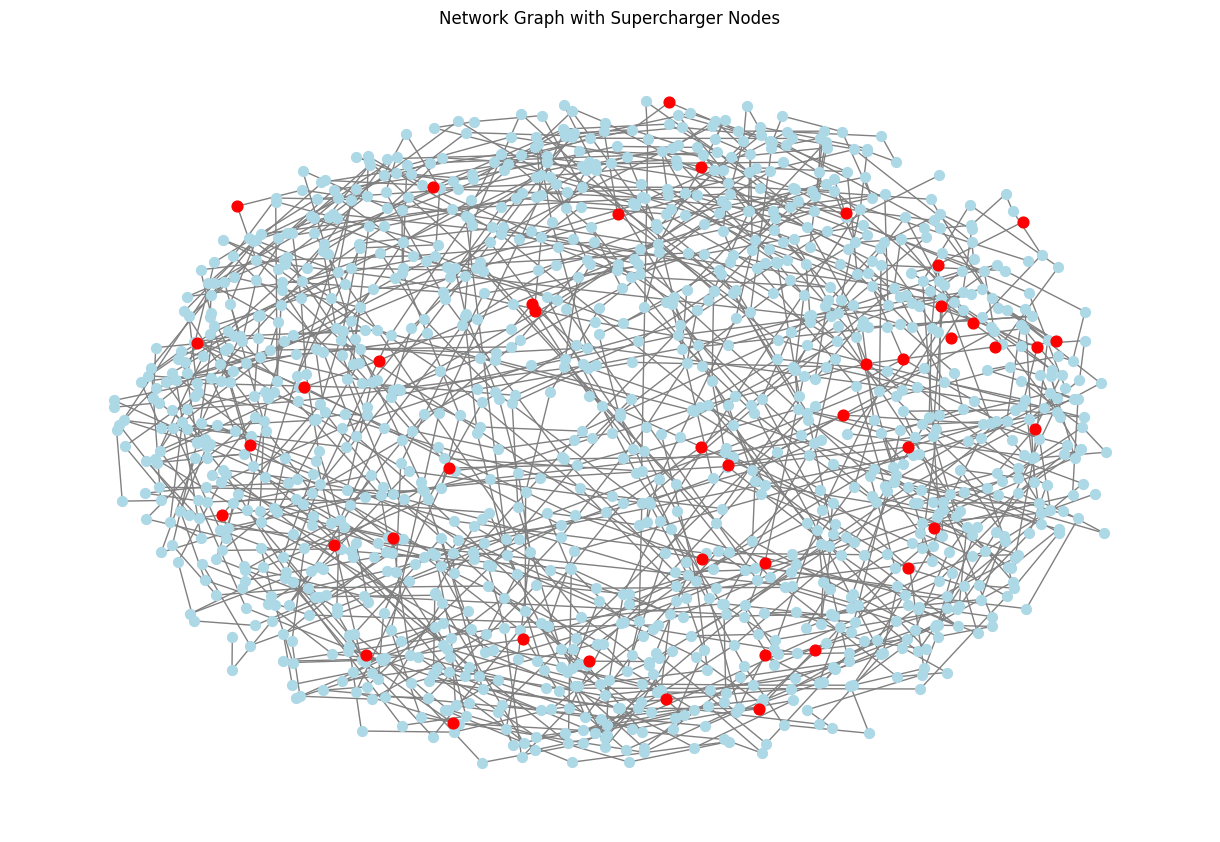

In [57]:
# Create a Graph
G = nx.Graph()

# Adding edges from the DataFrame
# Assuming your CSV has columns 'Node1', 'Node2', and 'Distance' for edges
for _, row in road_edge_data.iterrows():
    G.add_edge(row['Node1'], row['Node2'], weight=row['Distance'])

charger_nodes = [node for node in charger_nodes if node in G.nodes]

# Now plot the graph
plt.figure(figsize=(12, 8))

pos = nx.spring_layout(G)

# Draw all the nodes and edges
nx.draw(G, pos, with_labels=False, node_color='lightblue', edge_color='gray', node_size=50)

# Highlight the charger nodes
nx.draw_networkx_nodes(G, pos=pos, nodelist=charger_nodes, node_color='red', node_size=60)

plt.title("Network Graph with Supercharger Nodes")
plt.show()

In [58]:
def is_subpath(subpath, path):
    n = len(subpath)
    m = len(path)
    for i in range(m - n + 1):
        if path[i:i + n] == subpath:
            return True
    return False

In [59]:
def remove_subpaths(paths, distances):
    new_paths = []
    new_distances = []

    for i in range(len(paths)):
        add_path = True
        for j in range(len(paths)):
            if i != j and is_subpath(paths[i], paths[j]):
                add_path = False
                break
        if add_path:
            new_paths.append(paths[i])
            new_distances.append(distances[i])
    return new_paths, new_distances

In [60]:
sh_path_ranged = []
sh_path_dist_ranged = []

In [61]:
# Initialize lists for storing paths and distances
sh_path_ranged = []
sh_path_dist_ranged = []

# Calculate shortest paths and distances
for s, t in node_combinations:
    if s in G.nodes and t in G.nodes:  # Check if both nodes are in the graph
        try:
            shortest_distance = nx.shortest_path_length(G, source=s, target=t, weight='weight')
            if shortest_distance <= distance_range:
                shortest_path = nx.shortest_path(G, source=s, target=t, weight='weight')
                if OD_nodes[1] in shortest_path and shortest_path.index(OD_nodes[1]) == len(shortest_path) - 1:
                    sh_path_ranged.append(shortest_path)
                    sh_path_dist_ranged.append(shortest_distance)
                elif OD_nodes[1] not in shortest_path:
                    sh_path_ranged.append(shortest_path)
                    sh_path_dist_ranged.append(shortest_distance)
        except nx.NetworkXNoPath:
            print(f"No path between {s} and {t}")

# Remove subpaths from the lists
sh_path_ranged, sh_path_dist_ranged = remove_subpaths(sh_path_ranged, sh_path_dist_ranged)


In [62]:
merged_array_repo = []
distance_repo = []

In [63]:
def merge_arrays(arr1, arr2, dist1, dist2):
    if not arr1 or not arr2:
        return [], 0.0

    merged_array = arr1 + arr2[1:]
    merged_distance = dist1 + dist2

    return merged_array, merged_distance

In [64]:
def recursive_merging(input_array, input_distances):
    global merged_array_repo
    merged_array = []
    combined_listing = list(itertools.combinations(input_array, 2))
    combined_array = [list(combination) for combination in combined_listing]

    to_remove = []

    counter = 0
    for comb in combined_array:
        if comb[0][-1] == comb[1][0]:
            counter += 1

    if counter == 0:
        return merged_array_repo, distance_repo

    for comb in combined_array:
        if comb[0][-1] == comb[1][0]:
            merged_array, merged_distance = merge_arrays(
                comb[0], comb[1:][0], input_distances[input_array.index(comb[0])], input_distances[input_array.index(comb[1:][0])]
            )
            merged_array_repo.append(merged_array)
            distance_repo.append(merged_distance)
            to_remove.extend([comb[0], comb[1:][0]])

    merged_array_repo = [sublist for sublist in merged_array_repo if sublist not in to_remove]

    return recursive_merging(merged_array_repo, distance_repo)

In [65]:
list_of_paths, list_of_distances = recursive_merging(sh_path_ranged, sh_path_dist_ranged)

In [66]:
valid_paths = []
valid_distances = []
for each_path, each_distance in zip(list_of_paths, list_of_distances):
    if each_path[0] == OD_nodes[0] and each_path[-1] == OD_nodes[1]:
        valid_paths.append(each_path)
        valid_distances.append(each_distance)

In [67]:
# This finds the shortest path of all the shortest path for the 5C2 combinations
if distance_repo:
    min_distance_index = distance_repo.index(min(distance_repo))

    # Retrieve the corresponding path from list_of_paths
    shortest_path = list_of_paths[min_distance_index]
    shortest_distance = list_of_distances[min_distance_index]

    print(f"\nShortest Path: {shortest_path}, \n\nShortest Distance: {shortest_distance}")
else:
    print("\nNo valid paths found.")


Shortest Path: [16320.0, 16319.0, 16496.0, 16495.0, 16494.0, 16702.0, 16701.0, 16700.0, 16699.0, 16698.0, 16697.0, 16710.0, 16711.0, 16706.0, 16881.0, 16880.0, 16879.0, 16882.0, 16890.0, 16916.0, 16914.0, 17061.0, 17062.0, 17063.0, 17248.0, 17249.0, 17250.0, 17251.0, 17252.0, 17614.0, 17615.0, 17616.0, 17617.0, 17618.0, 17619.0, 17620.0, 17704.0, 17705.0, 17706.0, 17707.0, 17701.0, 17758.0, 17757.0, 17851.0, 17852.0, 17853.0, 17854.0, 17942.0, 17943.0, 17944.0, 17943.0, 17942.0, 17854.0, 17908.0, 17907.0, 17906.0, 17905.0, 17904.0, 17903.0, 17902.0, 17901.0, 17900.0, 18073.0, 18074.0], 

Shortest Distance: 0.223375


In [68]:
def evchargepath(OD_nodes, distance_range, charger_nodes, G):
    try:
        naive_shortest_distance = nx.shortest_path_length(G, source=OD_nodes[0], target=OD_nodes[1], weight='weight')
        if naive_shortest_distance <= distance_range:
            naive_shortest_path = nx.shortest_path(G, source=OD_nodes[0], target=OD_nodes[1], weight='weight')
            return naive_shortest_path, naive_shortest_distance
        else:
            sh_path_ranged = []
            sh_path_dist_ranged = []
            for s, t in node_combinations:
                shortest_distance = nx.shortest_path_length(G, source=s, target=t, weight='weight')
                if shortest_distance <= distance_range:
                    shortest_path = nx.shortest_path(G, source=s, target=t, weight='weight')
                    if OD_nodes[1] in shortest_path and shortest_path.index(OD_nodes[1]) == len(shortest_path) - 1:
                        sh_path_ranged.append(shortest_path)
                        sh_path_dist_ranged.append(shortest_distance)
                    elif OD_nodes[1] not in shortest_path:
                        sh_path_ranged.append(shortest_path)
                        sh_path_dist_ranged.append(shortest_distance)

            sh_path_ranged, sh_path_dist_ranged = remove_subpaths(sh_path_ranged, sh_path_dist_ranged)
            global merged_array_repo
            global distance_repo
            merged_array_repo = []
            distance_repo = []

            list_of_paths, list_of_distances = recursive_merging(sh_path_ranged, sh_path_dist_ranged)
            valid_paths = []
            valid_distances = []
            for each_path, each_distance in zip(list_of_paths, list_of_distances):
                if each_path[0] == OD_nodes[0] and each_path[-1] == OD_nodes[1]:
                    valid_paths.append(each_path)
                    valid_distances.append(each_distance)
            if valid_distances:
                min_distance_index = valid_distances.index(min(valid_distances))
                return valid_paths[min_distance_index], valid_distances[min_distance_index]
            else:
                return [], -1
    except nx.NetworkXNoPath:
        return [], -1

In [69]:
# Create a GeoDataFrame for the nodes
gdf_nodes = gpd.GeoDataFrame(
    road_node_data, 
    geometry=gpd.points_from_xy(road_node_data['Longitude'], road_node_data['Latitude'])
)

# Assuming 'df' contains edge information with 'Node1' and 'Node2'
edge_list = []
for _, edge in road_edge_data.iterrows():
    node1_coords = gdf_nodes.loc[gdf_nodes['Node'] == edge['Node1']].geometry.values[0]
    node2_coords = gdf_nodes.loc[gdf_nodes['Node'] == edge['Node2']].geometry.values[0]
    edge_list.append(LineString([node1_coords, node2_coords]))

gdf_edges = gpd.GeoDataFrame(geometry=edge_list)

In [70]:
# Create GeoDataFrame for superchargers
supercharger_points = gpd.GeoDataFrame(
    supercharger_data, 
    geometry=gpd.points_from_xy(supercharger_data['Longitude'], supercharger_data['Latitude'])
)

In [71]:
'''
# Calculate shortest path
shortest_path, shortest_distance = evchargepath(OD_nodes, distance_range, charger_nodes, G)

# Extract the coordinates for the shortest path
shortest_path_coords = [gdf_nodes.loc[gdf_nodes['Node'] == node].geometry.values[0] for node in shortest_path]
gdf_shortest_path = gpd.GeoDataFrame(geometry=[LineString(shortest_path_coords)])

# Plot
fig, ax = plt.subplots(figsize=(20, 20))

# Plotting the edges
gdf_edges.plot(ax=ax, linewidth=1, color='gray')

# Plotting the nodes
gdf_nodes.plot(ax=ax, color='blue', marker='o', label='Nodes', markersize=5)

# Plotting the shortest path
gdf_shortest_path.plot(ax=ax, linewidth=5, color='red', label='Shortest Path')

# Add grid, legend, and title
ax.grid(True)
ax.legend()
ax.set_title("Nodes, Superchargers, and Shortest Path Network")

plt.show()
'''

'\n# Calculate shortest path\nshortest_path, shortest_distance = evchargepath(OD_nodes, distance_range, charger_nodes, G)\n\n# Extract the coordinates for the shortest path\nshortest_path_coords = [gdf_nodes.loc[gdf_nodes[\'Node\'] == node].geometry.values[0] for node in shortest_path]\ngdf_shortest_path = gpd.GeoDataFrame(geometry=[LineString(shortest_path_coords)])\n\n# Plot\nfig, ax = plt.subplots(figsize=(20, 20))\n\n# Plotting the edges\ngdf_edges.plot(ax=ax, linewidth=1, color=\'gray\')\n\n# Plotting the nodes\ngdf_nodes.plot(ax=ax, color=\'blue\', marker=\'o\', label=\'Nodes\', markersize=5)\n\n# Plotting the shortest path\ngdf_shortest_path.plot(ax=ax, linewidth=5, color=\'red\', label=\'Shortest Path\')\n\n# Add grid, legend, and title\nax.grid(True)\nax.legend()\nax.set_title("Nodes, Superchargers, and Shortest Path Network")\n\nplt.show()\n'

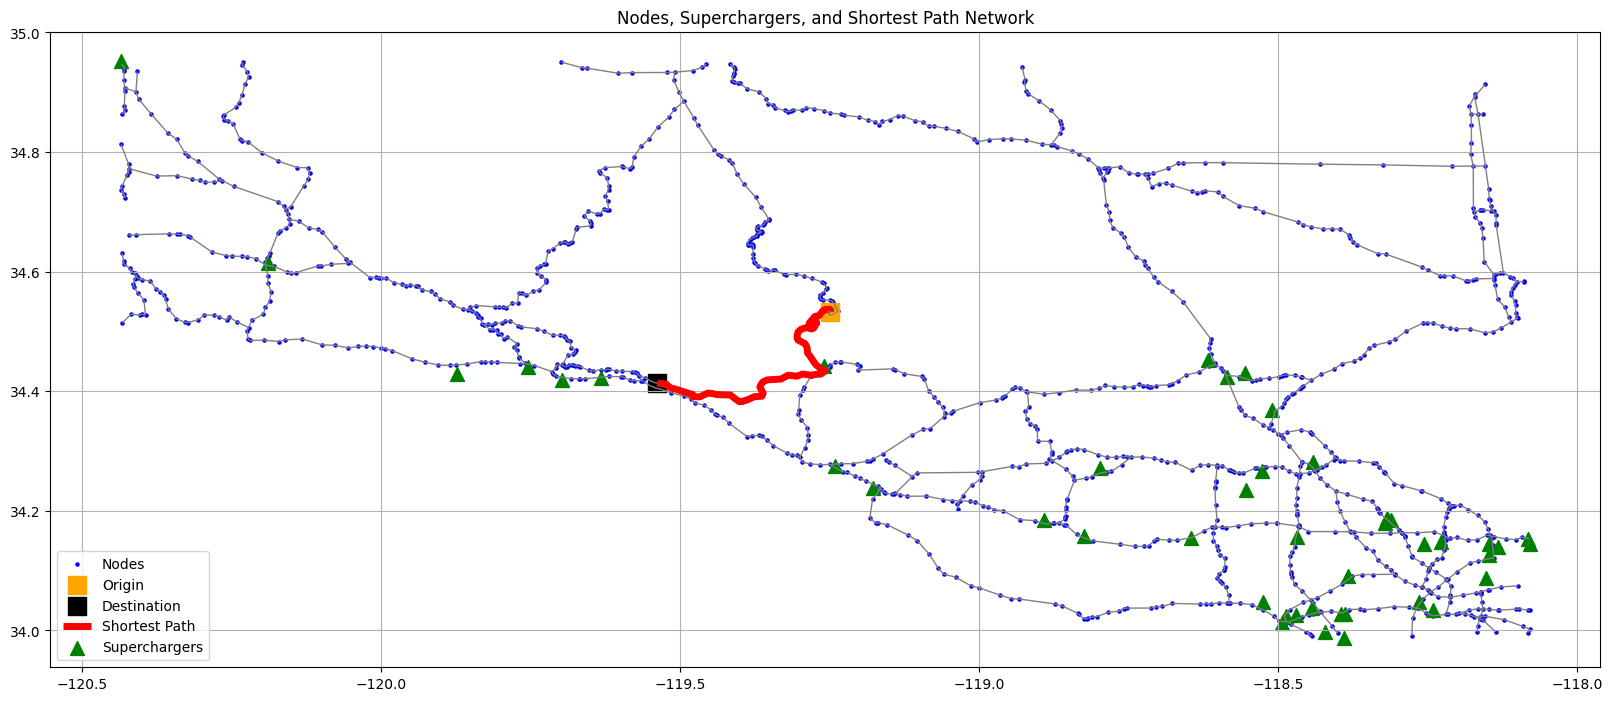

In [72]:
# Calculate shortest path
shortest_path, shortest_distance = evchargepath(OD_nodes, distance_range, charger_nodes, G)
origin_node = OD_nodes[0]  # First node is the origin
destination_node = OD_nodes[1]  # Second node is the destination

# Extract coordinates for the shortest path
shortest_path_coords = [gdf_nodes.loc[gdf_nodes['Node'] == node].geometry.values[0] for node in shortest_path]
gdf_shortest_path = gpd.GeoDataFrame(geometry=[LineString(shortest_path_coords)])

# Plot
fig, ax = plt.subplots(figsize=(20, 20))

# Plotting edges
gdf_edges.plot(ax=ax, linewidth=1, color='gray')

# Plotting nodes and highlighting origin and destination nodes
gdf_nodes.plot(ax=ax, color='blue', marker='o', label='Nodes', markersize=5)

# Extracting coordinates for origin and destination nodes
origin_coords = gdf_nodes.loc[gdf_nodes['Node'] == origin_node].geometry.values[0]
destination_coords = gdf_nodes.loc[gdf_nodes['Node'] == destination_node].geometry.values[0]

# Plotting origin node and destination node
gdf_nodes[gdf_nodes['Node'] == origin_node].plot(ax=ax, color='orange', marker='s', label='Origin', markersize=150)
gdf_nodes[gdf_nodes['Node'] == destination_node].plot(ax=ax, color='black', marker='s', label='Destination', markersize=150)

# Plotting shortest path
gdf_shortest_path.plot(ax=ax, linewidth=5, color='red', label='Shortest Path')

# Plotting superchargers
supercharger_points.plot(ax=ax, color='green', marker='^', label='Superchargers', markersize=100)

# Add grid, legend, and title
ax.grid(True)
ax.legend()
ax.set_title("Nodes, Superchargers, and Shortest Path Network")

plt.show()


Origin :  16411
Destination :  16638
Shortest Path :  [16411, 16410.0, 16409.0, 16408.0, 16407.0, 16406.0, 16405.0, 16404.0, 16403.0, 16402.0, 16401.0, 16400.0, 16399.0, 16398.0, 16397.0, 16396.0, 16395.0, 16394.0, 16393.0, 16392.0, 16391.0, 16390.0, 16389.0, 16388.0, 16387.0, 16386.0, 16385.0, 16384.0, 16383.0, 16382.0, 16381.0, 16380.0, 16379.0, 16497.0, 16498.0, 16499.0, 16611.0, 16612.0, 16613.0, 16614.0, 16615.0, 16616.0, 16617.0, 16618.0, 16619.0, 16620.0, 16621.0, 16622.0, 16623.0, 16624.0, 16625.0, 16626.0, 16627.0, 16628.0, 16629.0, 16630.0, 16631.0, 16632.0, 16633.0, 16634.0, 16635.0, 16636.0, 16637.0, 16638]
Shortest Distance :  2.25  including the distance of  1.73  that could have been travelled instead of charging




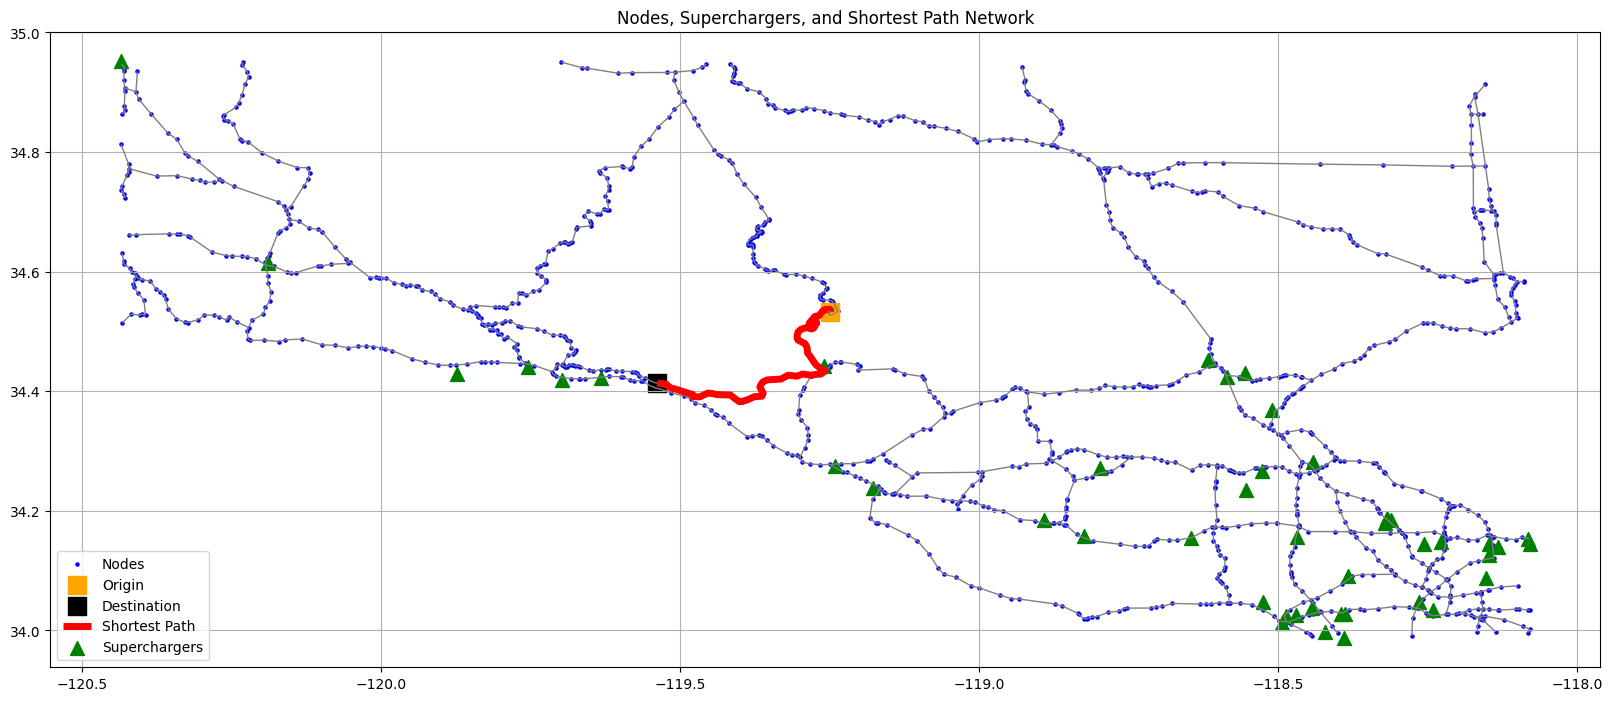

Origin :  16411
Destination :  16954
Shortest Path :  [16411, 16410.0, 16409.0, 16408.0, 16407.0, 16406.0, 16405.0, 16404.0, 16403.0, 16402.0, 16401.0, 16400.0, 16399.0, 16398.0, 16397.0, 16396.0, 16395.0, 16394.0, 16393.0, 16392.0, 16391.0, 16390.0, 16389.0, 16388.0, 16387.0, 16386.0, 16385.0, 16384.0, 16383.0, 16382.0, 16381.0, 16380.0, 16379.0, 16378.0, 16375.0, 16376.0, 16377.0, 16264.0, 16263.0, 16673.0, 16672.0, 16671.0, 16670.0, 16669.0, 16668.0, 16667.0, 16666.0, 16665.0, 16664.0, 16663.0, 16680.0, 16681.0, 16679.0, 16674.0, 16675.0, 16676.0, 16677.0, 16678.0, 16583.0, 16584.0, 16585.0, 16586.0, 16587.0, 16588.0, 16582.0, 16581.0, 16580.0, 16579.0, 16578.0, 16577.0, 16576.0, 16575.0, 16574.0, 16573.0, 16572.0, 16571.0, 16570.0, 16569.0, 16568.0, 16567.0, 16566.0, 16565.0, 16564.0, 16563.0, 16562.0, 16561.0, 16319.0, 16496.0, 16495.0, 16494.0, 16702.0, 16701.0, 16700.0, 16699.0, 16698.0, 16697.0, 16710.0, 16711.0, 16706.0, 16881.0, 16880.0, 16879.0, 16882.0, 16895.0, 16954]
Shor

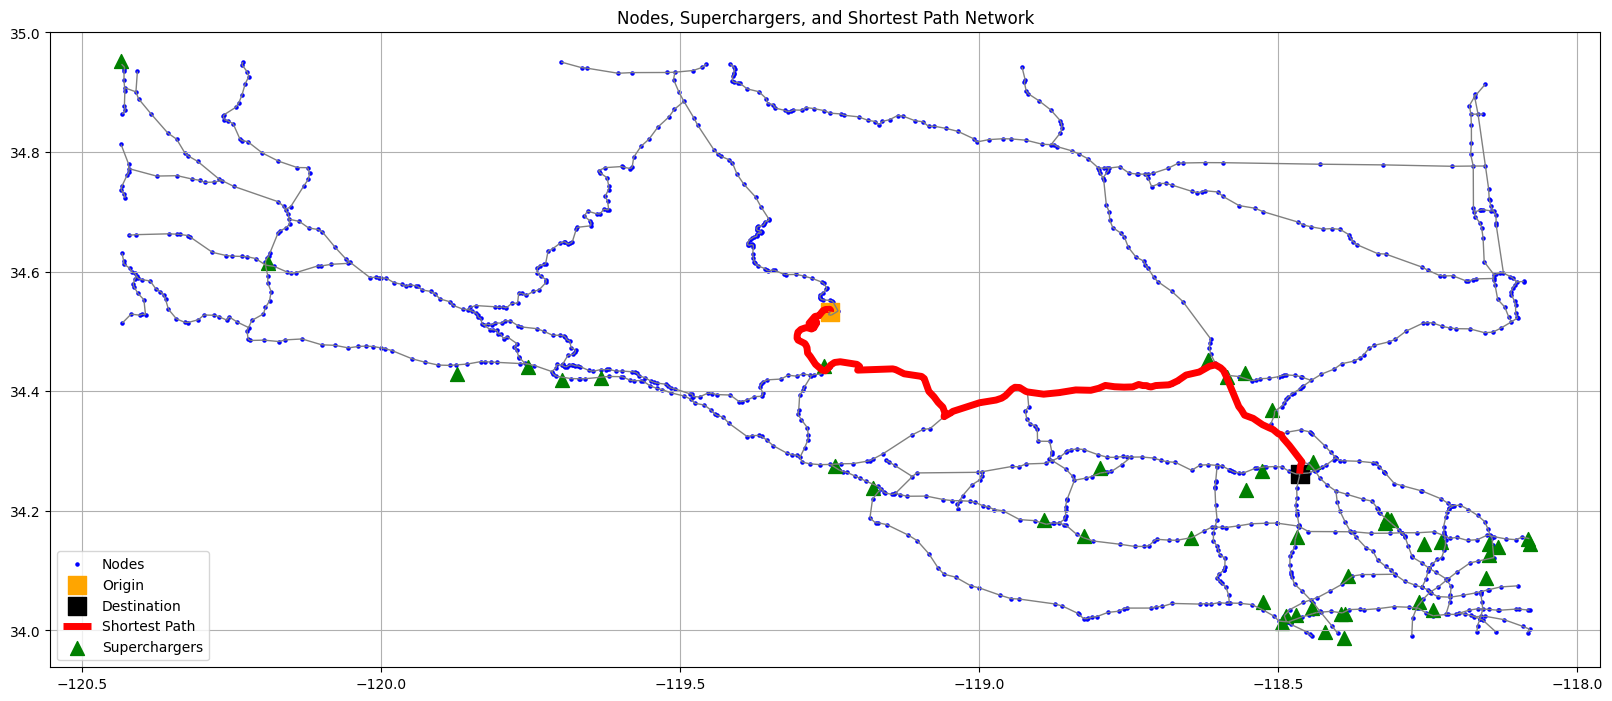

Origin :  16638
Destination :  16954
Shortest Path :  [16638, 16637.0, 16636.0, 16635.0, 16634.0, 16633.0, 16632.0, 16631.0, 16630.0, 16629.0, 16628.0, 16627.0, 16626.0, 16625.0, 16624.0, 16623.0, 16622.0, 16621.0, 16620.0, 16619.0, 16618.0, 16617.0, 16616.0, 16615.0, 16614.0, 16613.0, 16612.0, 16611.0, 16499.0, 16498.0, 16497.0, 16379.0, 16378.0, 16375.0, 16376.0, 16377.0, 16264.0, 16263.0, 16673.0, 16672.0, 16671.0, 16670.0, 16669.0, 16668.0, 16667.0, 16666.0, 16665.0, 16664.0, 16663.0, 16680.0, 16681.0, 16679.0, 16674.0, 16675.0, 16676.0, 16677.0, 16678.0, 16583.0, 16584.0, 16585.0, 16586.0, 16587.0, 16588.0, 16582.0, 16581.0, 16580.0, 16579.0, 16578.0, 16577.0, 16576.0, 16575.0, 16574.0, 16573.0, 16572.0, 16571.0, 16570.0, 16569.0, 16568.0, 16567.0, 16566.0, 16565.0, 16564.0, 16563.0, 16562.0, 16561.0, 16319.0, 16496.0, 16495.0, 16494.0, 16702.0, 16701.0, 16700.0, 16699.0, 16698.0, 16697.0, 16710.0, 16711.0, 16706.0, 16881.0, 16880.0, 16879.0, 16882.0, 16895.0, 16954]
Shortest Dist

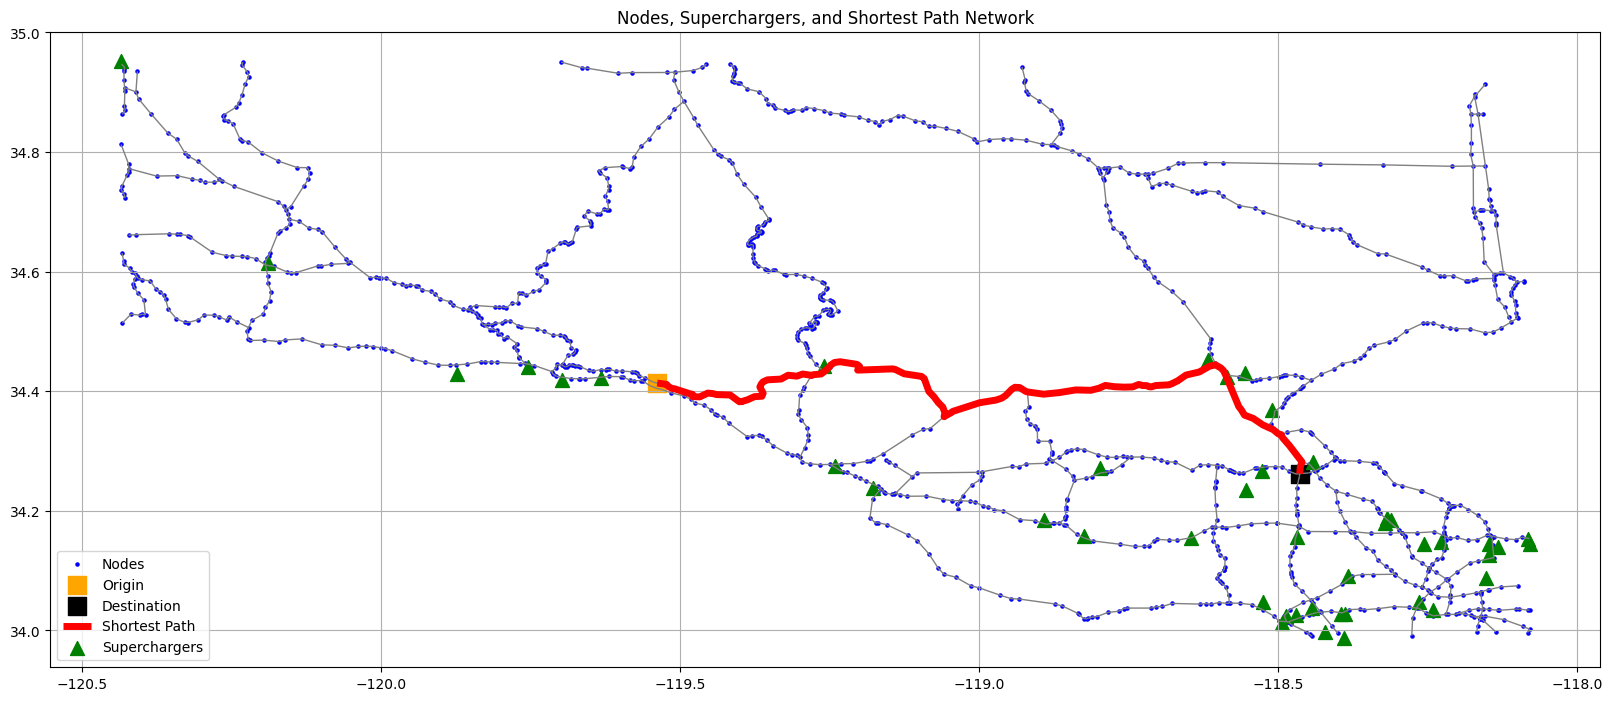

Origin :  15466
Destination :  16411
No Path Found




/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/plotting.py:979: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  return plot_dataframe(data, *args, **kwargs)


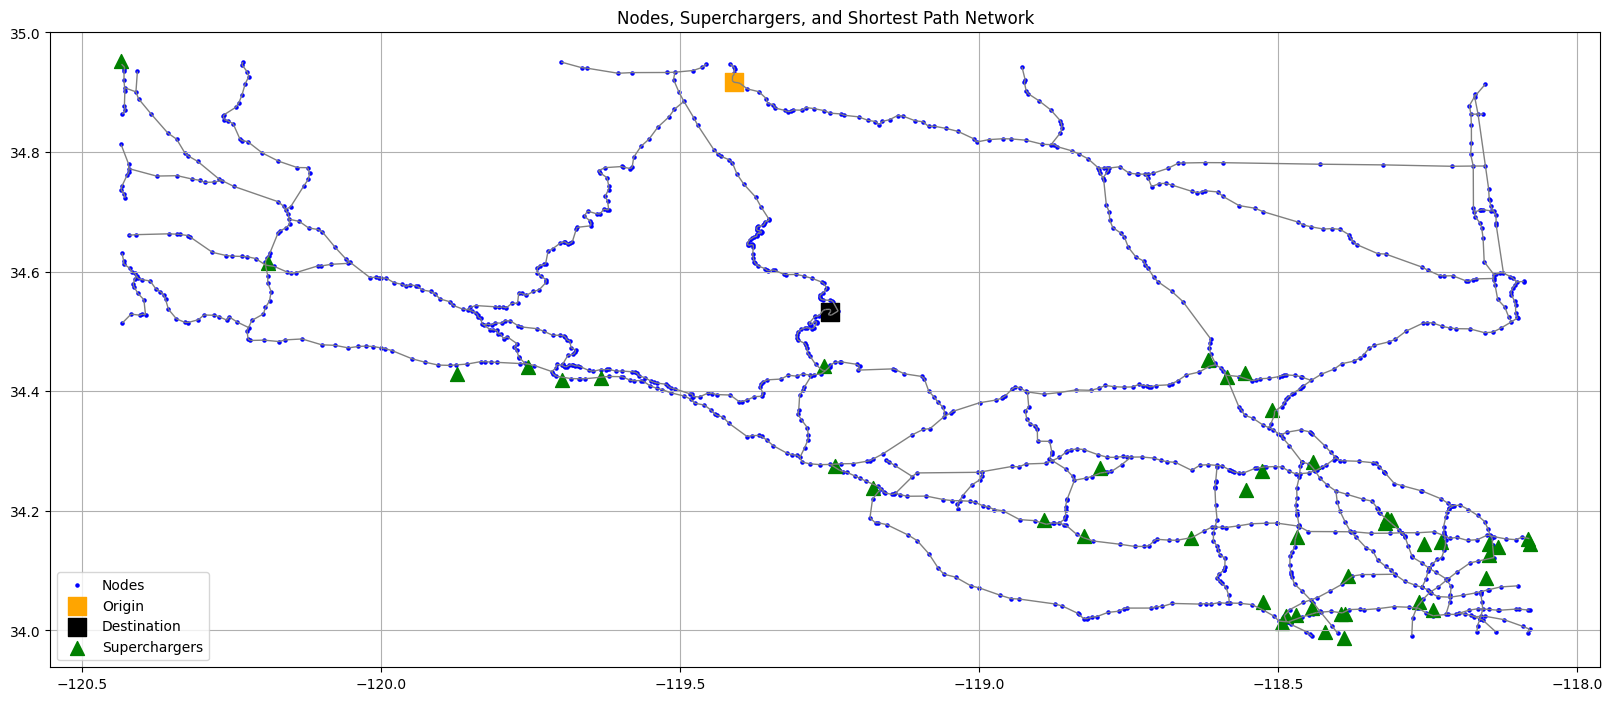

Origin :  15466
Destination :  16638
No Path Found




/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/plotting.py:979: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  return plot_dataframe(data, *args, **kwargs)


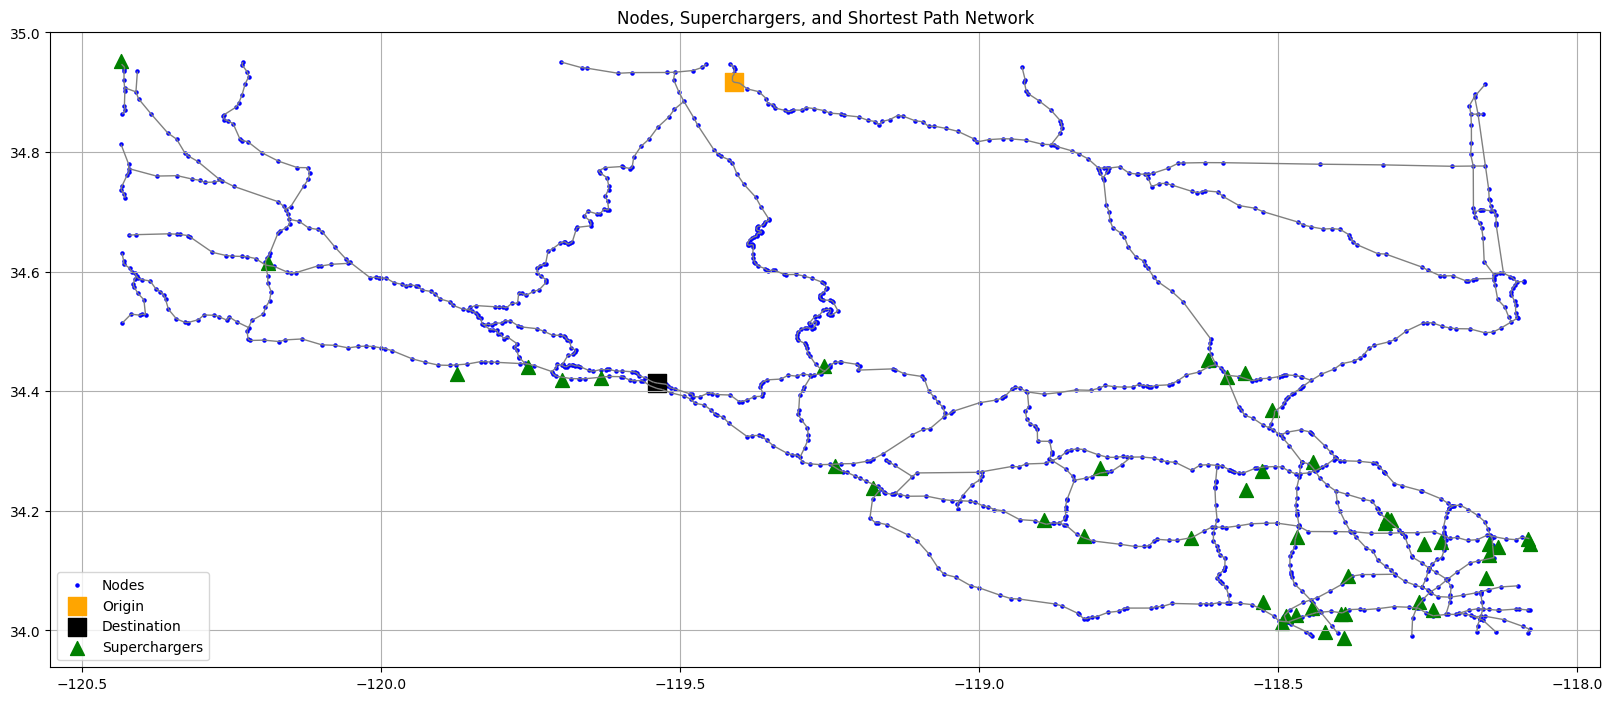

Origin :  15466
Destination :  16954
Shortest Path :  [15466, 15467.0, 15468.0, 15469.0, 15470.0, 15471.0, 15472.0, 15473.0, 15474.0, 15475.0, 15476.0, 15477.0, 15478.0, 15479.0, 15480.0, 15481.0, 15482.0, 15483.0, 15484.0, 15485.0, 15486.0, 15487.0, 15488.0, 15489.0, 15490.0, 15491.0, 15492.0, 15493.0, 15494.0, 15495.0, 15496.0, 15497.0, 15498.0, 15499.0, 15500.0, 15501.0, 15502.0, 15503.0, 15504.0, 15505.0, 15506.0, 15457.0, 15530.0, 15529.0, 15528.0, 15527.0, 15526.0, 15525.0, 15584.0, 15585.0, 15581.0, 16340.0, 16339.0, 16338.0, 16337.0, 16336.0, 16335.0, 16334.0, 16333.0, 16332.0, 16331.0, 16330.0, 16329.0, 16328.0, 16327.0, 16326.0, 16325.0, 16324.0, 16323.0, 16322.0, 16321.0, 16320.0, 16319.0, 16496.0, 16495.0, 16494.0, 16702.0, 16701.0, 16700.0, 16699.0, 16698.0, 16697.0, 16710.0, 16711.0, 16706.0, 16881.0, 16880.0, 16879.0, 16882.0, 16895.0, 16954]
Shortest Distance :  5.69  including the distance of  4.37  that could have been travelled instead of charging




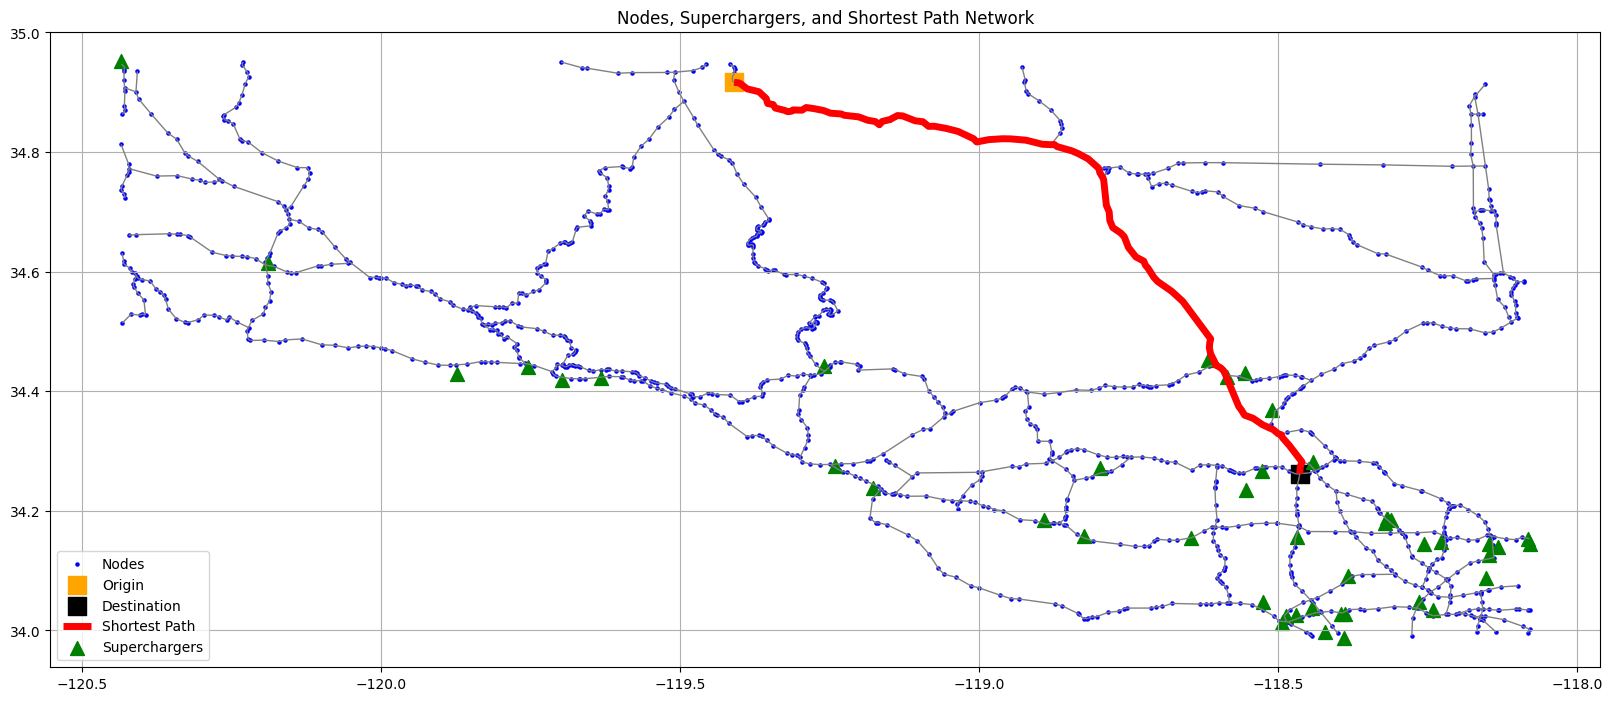

Origin :  15466
Destination :  16261
No Path Found




/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/geopandas/plotting.py:979: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  return plot_dataframe(data, *args, **kwargs)


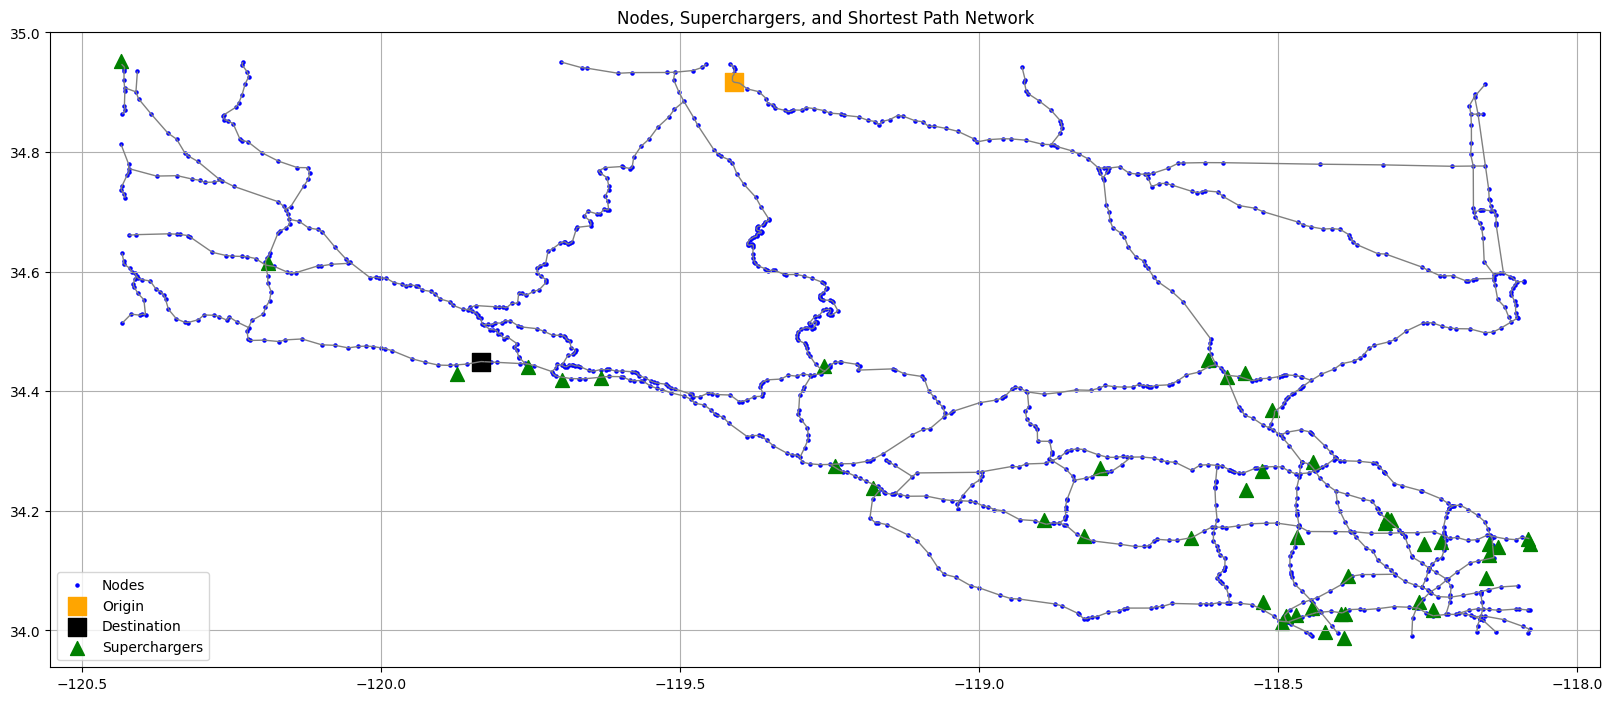

Origin :  16261
Destination :  16411
Shortest Path :  [16261, 16262.0, 16265.0, 16266.0, 16267.0, 16269.0, 16481.0, 16479.0, 16480.0, 16366.0, 16365.0, 16662.0, 16661.0, 16660.0, 16659.0, 16658.0, 16657.0, 16656.0, 16655.0, 16654.0, 16653.0, 16652.0, 16651.0, 16650.0, 16649.0, 16648.0, 16647.0, 16646.0, 16645.0, 16644.0, 16643.0, 16642.0, 16641.0, 16640.0, 16639.0, 16638.0, 16637.0, 16636.0, 16635.0, 16634.0, 16633.0, 16632.0, 16631.0, 16630.0, 16629.0, 16628.0, 16627.0, 16626.0, 16625.0, 16624.0, 16623.0, 16622.0, 16621.0, 16620.0, 16619.0, 16618.0, 16617.0, 16616.0, 16615.0, 16614.0, 16613.0, 16612.0, 16611.0, 16499.0, 16498.0, 16497.0, 16379.0, 16380.0, 16381.0, 16382.0, 16383.0, 16384.0, 16385.0, 16386.0, 16387.0, 16388.0, 16389.0, 16390.0, 16391.0, 16392.0, 16393.0, 16394.0, 16395.0, 16396.0, 16397.0, 16398.0, 16399.0, 16400.0, 16401.0, 16402.0, 16403.0, 16404.0, 16405.0, 16406.0, 16407.0, 16408.0, 16409.0, 16410.0, 16411]
Shortest Distance :  3.61  including the distance of  2.77

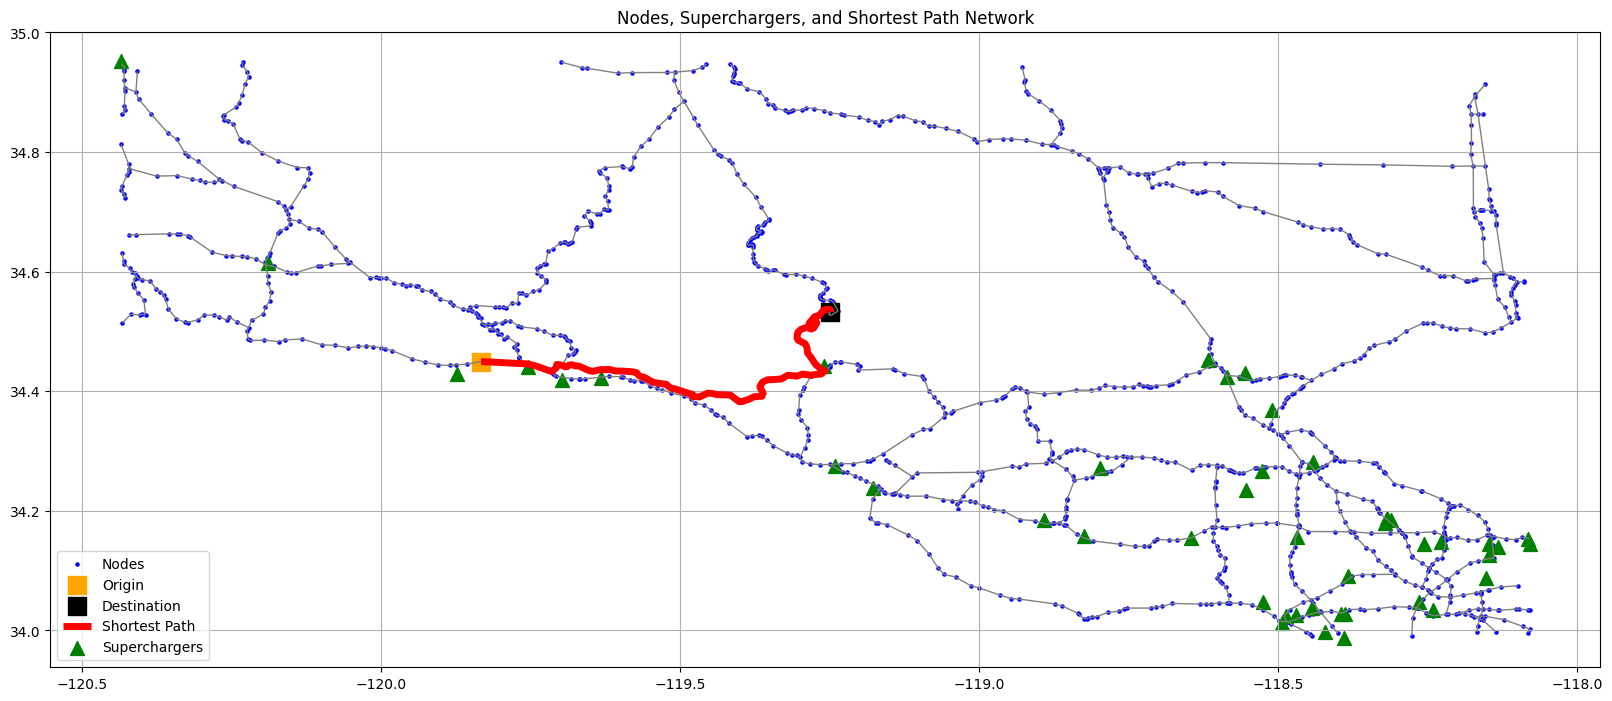

Origin :  16261
Destination :  16638
Shortest Path :  [16261, 16262.0, 16265.0, 16266.0, 16267.0, 16269.0, 16481.0, 16479.0, 16480.0, 16366.0, 16365.0, 16662.0, 16661.0, 16660.0, 16659.0, 16658.0, 16657.0, 16656.0, 16655.0, 16654.0, 16653.0, 16652.0, 16651.0, 16650.0, 16649.0, 16648.0, 16647.0, 16646.0, 16645.0, 16644.0, 16643.0, 16642.0, 16641.0, 16640.0, 16639.0, 16638]
Shortest Distance :  1.36  including the distance of  1.04  that could have been travelled instead of charging




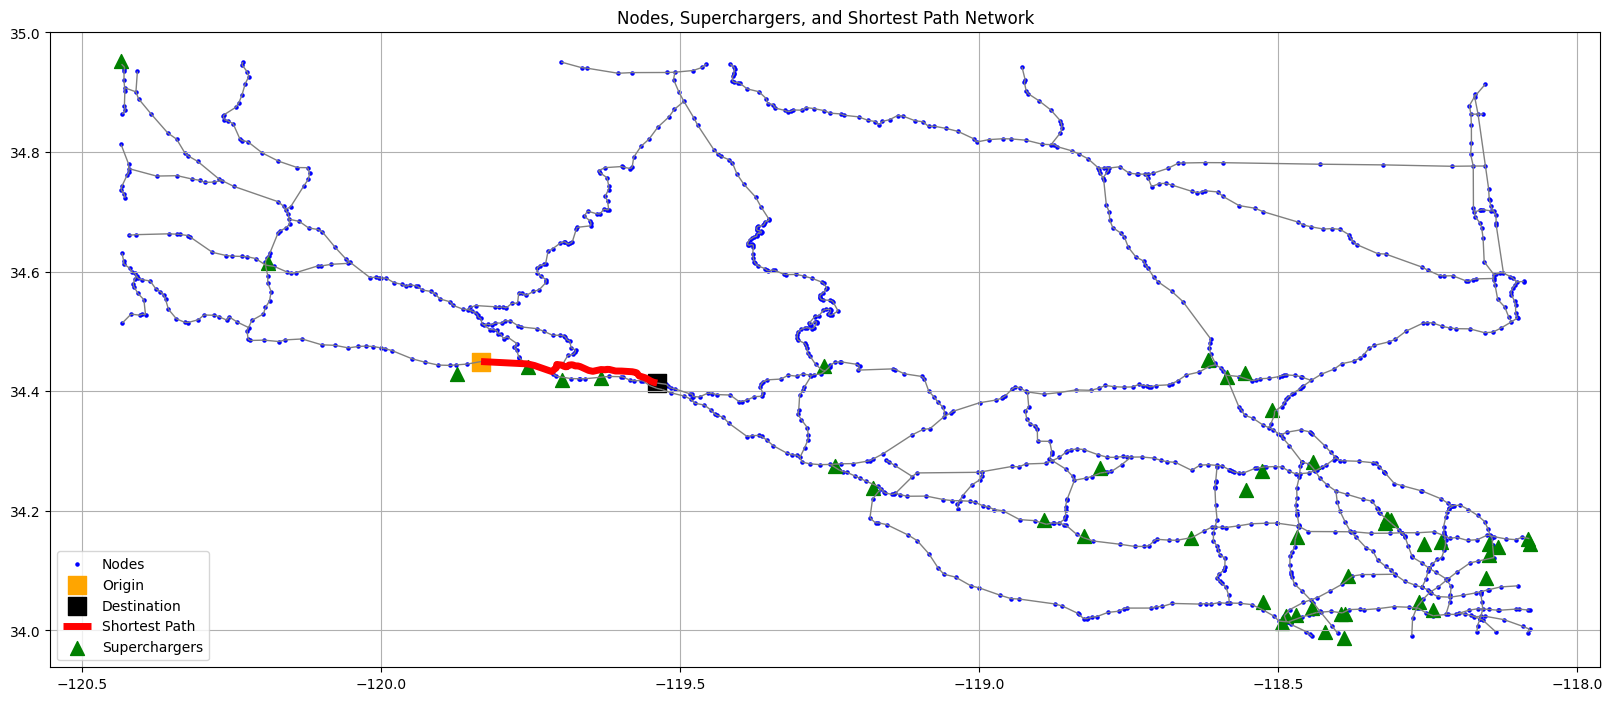

Origin :  16261
Destination :  16954
Shortest Path :  [16261, 16262.0, 16265.0, 16266.0, 16267.0, 16269.0, 16481.0, 16479.0, 16528.0, 16527.0, 16526.0, 16525.0, 16529.0, 16836.0, 16835.0, 16834.0, 16833.0, 16832.0, 16831.0, 16830.0, 16829.0, 16828.0, 16827.0, 16826.0, 16825.0, 16824.0, 16823.0, 16822.0, 16821.0, 16820.0, 16819.0, 16818.0, 16817.0, 16816.0, 16815.0, 16814.0, 16813.0, 16812.0, 16811.0, 16810.0, 16809.0, 16808.0, 16807.0, 16803.0, 16883.0, 16893.0, 16894.0, 16892.0, 16907.0, 16908.0, 16975.0, 16974.0, 16973.0, 16999.0, 17038.0, 17037.0, 17042.0, 17064.0, 17067.0, 17070.0, 17069.0, 17068.0, 16978.0, 16977.0, 16976.0, 16941.0, 16942.0, 16943.0, 16944.0, 16888.0, 16859.0, 16802.0, 16801.0, 16800.0, 16799.0, 16798.0, 16797.0, 16796.0, 16795.0, 16794.0, 16793.0, 16791.0, 16790.0, 16875.0, 16876.0, 16877.0, 16878.0, 16910.0, 16911.0, 16912.0, 16913.0, 16898.0, 16905.0, 16906.0, 16909.0, 16938.0, 16949.0, 16950.0, 16952.0, 16953.0, 16902.0, 16903.0, 16904.0, 16964.0, 16965.0, 16

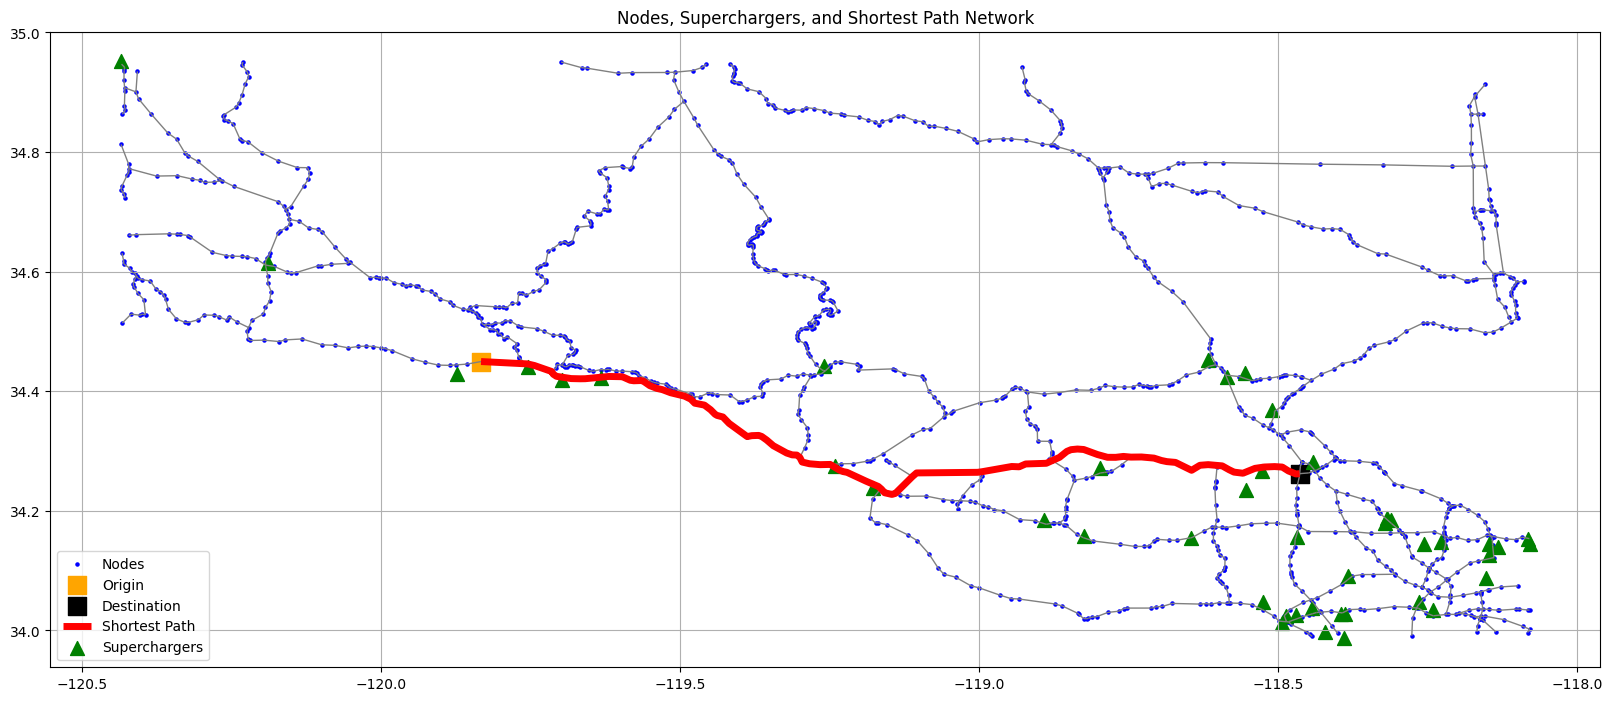

In [76]:
heatmap_data = {}

for origin in sample_nodes:
    for destination in sample_nodes:
        # if i<j and i not in charger_nodes and j not in charger_nodes:
        if origin<destination:
            
            penalty = 0
            OD_nodes[0] = origin
            OD_nodes[1] = destination
            print("Origin : ", OD_nodes[0])
            print("Destination : ",OD_nodes[1])
            
            shortest_path, shortest_distance = evchargepath(OD_nodes, distance_range, charger_nodes, G)
            
            penalty = (shortest_distance/distance_range)*waiting_penalty
            final_shortest_distance = shortest_distance+penalty

            heatmap_data[(OD_nodes[0], OD_nodes[1])] = final_shortest_distance
            
            if final_shortest_distance > 0:
                print("Shortest Path : ",shortest_path)
                print("Shortest Distance : ", round(final_shortest_distance,2) , " including the distance of ",round(penalty,2), " that could have been travelled instead of charging")
            else:
                print("No Path Found")
            print("\n")
            
            # Extract coordinates for the shortest path
            shortest_path_coords = [gdf_nodes.loc[gdf_nodes['Node'] == node].geometry.values[0] for node in shortest_path]
            gdf_shortest_path = gpd.GeoDataFrame(geometry=[LineString(shortest_path_coords)])

            # Plot
            fig, ax = plt.subplots(figsize=(20, 20))

            # Plotting edges
            gdf_edges.plot(ax=ax, linewidth=1, color='gray')

            # Plotting nodes
            gdf_nodes.plot(ax=ax, color='blue', marker='o', label='Nodes', markersize=5)
            
            # Extracting coordinates for origin and destination nodes
            origin_coords = gdf_nodes.loc[gdf_nodes['Node'] == origin].geometry.values[0]
            destination_coords = gdf_nodes.loc[gdf_nodes['Node'] == destination].geometry.values[0]

            # Plotting origin node and destination node
            gdf_nodes[gdf_nodes['Node'] == origin].plot(ax=ax, color='orange', marker='s', label='Origin', markersize=150)
            gdf_nodes[gdf_nodes['Node'] == destination].plot(ax=ax, color='black', marker='s', label='Destination', markersize=150)


            # Plotting shortest path
            gdf_shortest_path.plot(ax=ax, linewidth=5, color='red', label='Shortest Path')

            # Plotting superchargers
            supercharger_points.plot(ax=ax, color='green', marker='^', label='Superchargers', markersize=100)

            # Add grid, legend, and title
            ax.grid(True)
            ax.legend()
            ax.set_title("Nodes, Superchargers, and Shortest Path Network")

            plt.show()


			 HEAT MAP


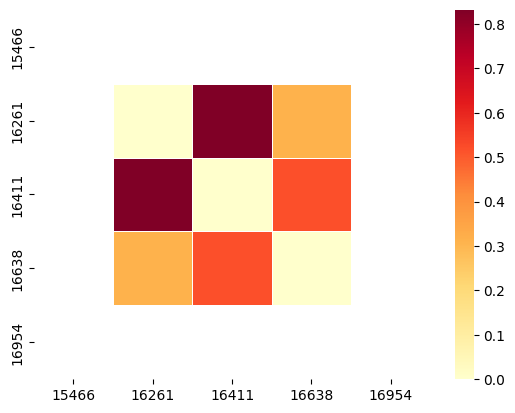

In [74]:
print("="*100)
print("\t"*3,"HEAT MAP")
print("="*100)

# Create a DataFrame for the heatmap
df_heatmap = pd.DataFrame(list(heatmap_data.items()), columns=['OD_nodes', 'final_shortest_distance'])

# Split 'OD_nodes' into two separate columns
df_heatmap[['Origin_node', 'Destination_node']] = pd.DataFrame(df_heatmap['OD_nodes'].tolist(), index=df_heatmap.index)

# Pivot the DataFrame to create a matrix for the heatmap
heatmap_matrix = df_heatmap.pivot(index='Origin_node', columns='Destination_node', values='final_shortest_distance')

heatmap_matrix[np.isnan(heatmap_matrix)]=0
heatmap_matrix = heatmap_matrix + heatmap_matrix.transpose()

mask = (heatmap_matrix == -1)
heatmap_matrix_colored = heatmap_matrix.mask(mask, -1)
# Create the heatmap using seaborn
sns.heatmap(heatmap_matrix, annot=False, cmap="YlOrRd", fmt=".1f", linewidths=.5)
# sns.heatmap(heatmap_matrix, annot=False, cmap="Reds", fmt=".1f", linewidths=.5, vmin=-1, vmax=heatmap_matrix.values.max(), cbar_kws={'label': 'Final Shortest Distance'})

# # Add red color for cells with value -1
# sns.heatmap(heatmap_matrix, mask=(heatmap_matrix == -1), cmap='Reds', cbar=False, annot=False)

# Show the plot
plt.show()